# PCA Analysis for Milestone 2

In [163]:
# Import the required libraries
import pandas as pd
import numpy as np
import yfinance as yf
import pandas_datareader as pdr
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

### Functions to fetch, clean, and preprocess the data

In [164]:
def fetch_yahoo_data(tickers, start_date, end_date):
    """Fetches financial data from Yahoo Finance."""
    df = yf.download(tickers, start=start_date, end=end_date)
    df = df.ffill().resample("D").ffill()
    df.columns = ["_".join(col).strip() for col in df.columns.values]
    return df


def clean_data(df):
    """Cleans the data by dropping unnecessary columns."""
    df = df.drop(
        columns=[col for col in df.columns if "Close" in col and "Adj" not in col]
    )
    if "Volume_DX-Y.NYB" in df.columns:
        df = df.drop(columns=["Volume_DX-Y.NYB"])
    return df


def create_column_mapping(tickers):
    """Creates a mapping for column renaming."""
    column_mapping = {}
    asset_names = {
        "COIN": "coinbase",
        "BTC-USD": "bitcoin",
        "ETH-USD": "ethereum",
        "GC=F": "gold",
        "DX-Y.NYB": "us_dollar_index",
    }
    columns = ["Adj Close", "High", "Low", "Open", "Volume"]

    for ticker in tickers:
        asset = asset_names.get(ticker, ticker)
        for col in columns:
            old_col = f"{col}_{ticker}"
            if col == "Adj Close":
                new_col = f"{asset}_price"
            else:
                new_col = f"{asset}_{col.lower().replace(' ', '_')}"
            column_mapping[old_col] = new_col

    return column_mapping


def rename_columns(df, column_mapping):
    """Renames the columns based on the provided mapping."""
    return df.rename(columns=column_mapping)


def calculate_returns(df):
    """Calculates daily returns for specific assets."""
    for asset in ["bitcoin", "coinbase", "ethereum", "gold"]:
        price_col = f"{asset}_price"
        if price_col in df.columns:
            df[f"{asset}_return"] = df[price_col].pct_change()
        else:
            print(
                f"Warning: {price_col} not found in dataframe. Skipping return calculation."
            )
    return df


def order_columns(df):
    """Orders the columns with key columns at the front."""
    key_columns = ["coinbase_price", "bitcoin_price", "ethereum_price"]
    remaining_columns = [col for col in df.columns if col not in key_columns]
    return df[key_columns + remaining_columns]


def fetch_and_process_financial_data(tickers, start_date, end_date):
    """Main function to fetch and process financial data."""
    df = fetch_yahoo_data(tickers, start_date, end_date)
    df = clean_data(df)
    column_mapping = create_column_mapping(tickers)
    df = rename_columns(df, column_mapping)
    df = calculate_returns(df)
    df = order_columns(df)
    return df

In [165]:
def fetch_and_resample_fred(series_id, start_date, end_date, freq="D"):
    """Fetches data from FRED (Federal Reserve Economic Data) and resamples it to a daily frequency.

    Args:
        series_id (str or list): The FRED series ID(s) to fetch.
        start_date (datetime): The start date of the data range.
        end_date (datetime): The end date of the data range.

    Returns:
        pandas.DataFrame or None: A DataFrame containing the resampled data, or None if an error occurs during fetching.

    Raises:
        None: This function does not raise any specific exceptions, but it may print an error message if data fetching fails.
    """
    try:
        data = (
            pdr.get_data_fred(series_id, start_date, end_date)
            .ffill()
            .resample(freq)
            .ffill()
        )
        # Reindex the data to include all days between start_date and end_date
        data = data.reindex(pd.date_range(start_date, end_date, freq="D"))
        data = data.ffill().bfill()
        return data
    except Exception as e:
        print(f"Error fetching {series_id}: {e}")
        return None

### Fetch financial data from Yahoo Finance

In [166]:
# Define the tickers to fetch
tickers = ["COIN", "BTC-USD", "ETH-USD", "GC=F", "DX-Y.NYB"]

# Define the date range
start_date = datetime(2021, 4, 14)  # Date of Coinbase IPO
end_date = datetime.now()

# Fetch and process the financial data
financial_data = fetch_and_process_financial_data(tickers, start_date, end_date)

# Display the first few rows of the financial data
financial_data.head()

[*********************100%%**********************]  5 of 5 completed


,coinbase_price,bitcoin_price,ethereum_price,us_dollar_index_price,gold_price,bitcoin_high,coinbase_high,us_dollar_index_high,ethereum_high,gold_high,...,ethereum_open,gold_open,bitcoin_volume,coinbase_volume,ethereum_volume,gold_volume,bitcoin_return,coinbase_return,ethereum_return,gold_return
Date,,,,,,,,,,,,,,,,,,,,,
2021-04-14,328.279999,63109.695312,2435.104980,91.690002,1734.900024,64863.097656,429.540009,91.830002,2449.687500,1745.900024,...,2299.347900,1741.300049,77451779687,81065700.0,35592822986,1037.0,NaN,NaN,NaN,NaN
2021-04-15,322.750000,63314.011719,2519.116211,91.669998,1765.400024,63821.671875,349.200012,91.750000,2544.267334,1767.900024,...,2436.034668,1740.099976,60954381579,39777900.0,32325606817,368.0,0.003237,-0.016845,0.034500,0.017580
2021-04-16,342.000000,61572.789062,2431.946533,91.559998,1779.000000,63594.722656,345.989990,91.809998,2547.555664,1779.500000,...,2516.601807,1770.400024,84293007468,22654500.0,36196928256,625.0,-0.027501,0.059644,-0.034603,0.007704
2021-04-17,342.000000,60683.820312,2344.895020,91.559998,1779.000000,62572.175781,345.989990,91.809998,2497.385254,1779.500000,...,2429.980957,1770.400024,66138759198,22654500.0,32349808978,625.0,-0.014438,0.000000,-0.035795,0.000000
2021-04-18,342.000000,56216.183594,2237.136963,91.559998,1779.000000,61057.457031,345.989990,91.809998,2365.460449,1779.500000,...,2346.452393,1770.400024,97468872758,22654500.0,50696368718,625.0,-0.073622,0.000000,-0.045954,0.000000


### Fetch the economic data from FRED

In [167]:
import pandas as pd

# Define a dictionary mapping FRED series IDs to desired column names
fred_data_mapping = {
    "FEDFUNDS": "fed_funds_rate",
    "DSPIC96": "real_disposable_income",
    "GDPC1": "real_gdp",
    "UNRATE": "unemployment_rate",
    "UMCSENT": "michigan_sentiment",
    "CPILFESL": "core_cpi",
    "PPIACO": "producer_price_index",
    "WM2NS": "m2_money_supply",
}

# List of treasury yields to fetch
treasuries = [
    "DGS3MO", "DGS6MO", "DGS1", "DGS2", "DGS3",
    "DGS5", "DGS7", "DGS10", "DGS20", "DGS30",
]

# Initialize an empty list to store DataFrames
econ_data_list = []

# Fetch and process data from FRED
for series_id, col_name in fred_data_mapping.items():
    data = fetch_and_resample_fred(series_id, start_date, end_date)
    if data is not None:
        data = data.rename(columns={series_id: col_name})
        econ_data_list.append(data)
    else:
        print(f"Failed to fetch data for {series_id}")

# Fetch and process treasury data
treasuries_data = fetch_and_resample_fred(treasuries, start_date, end_date)
if treasuries_data is not None:
    econ_data_list.append(treasuries_data)
else:
    print("Failed to fetch treasury data")

# Combine all economic data into a single DataFrame
if econ_data_list:
    # Create a common date range for all data
    date_range = pd.date_range(start=start_date, end=end_date, freq='D')
    
    # Reindex all DataFrames to the common date range
    econ_data_list = [df.reindex(date_range) for df in econ_data_list]
    
    # Concatenate all DataFrames
    econ_data = pd.concat(econ_data_list, axis=1)
    
    # Calculate yield curve spread
    # if 'DGS10' in econ_data.columns and 'DGS2' in econ_data.columns:
    #     econ_data['yield_curve_spread'] = econ_data['DGS10'] - econ_data['DGS2']
    
    # Check for and report any missing data
    missing_data = econ_data.isnull().sum()
    if missing_data.any():
        print("Missing data in the following columns:")
        print(missing_data[missing_data > 0])
    
    # Show the economic data
    print(econ_data.head())
else:
    print("No economic data was successfully fetched.")

            fed_funds_rate  real_disposable_income   real_gdp  \
2021-04-14            0.06                 16819.1  21483.083   
2021-04-15            0.06                 16819.1  21483.083   
2021-04-16            0.06                 16819.1  21483.083   
2021-04-17            0.06                 16819.1  21483.083   
2021-04-18            0.06                 16819.1  21483.083   

            unemployment_rate  michigan_sentiment  core_cpi  \
2021-04-14                5.8                82.9   275.494   
2021-04-15                5.8                82.9   275.494   
2021-04-16                5.8                82.9   275.494   
2021-04-17                5.8                82.9   275.494   
2021-04-18                5.8                82.9   275.494   

            producer_price_index  m2_money_supply  DGS3MO  DGS6MO  DGS1  DGS2  \
2021-04-14                 224.9          20280.4    0.02    0.04  0.06  0.16   
2021-04-15                 224.9          20280.4    0.02    0.04  0

### Combine the financial and economic data and perform feature engineering

In [168]:
def add_technical_indicators(df, asset_name):
    """Add technical indicators to the DataFrame.

    Args:
        df (pd.DataFrame): The DataFrame to which to add the technical indicators.
        asset_name (str): The name of the asset.

    Returns:
        pd.DataFrame: The DataFrame with the technical indicators added.
    """
    price = df[f"{asset_name}_price"]
    volume = df[f"{asset_name}_volume"]

    # Define the lagged values of the price and volume
    for lag in range(1, 8):
        df[f"{asset_name}_price_lag_{lag}"] = price.shift(lag)
        df[f"{asset_name}_volume_lag_{lag}"] = volume.shift(lag)

    # Calculate the moving averages
    for window in [5, 10, 20, 50, 100, 200]:
        df[f"{asset_name}_sma_{window}"] = (
            df[f"{asset_name}_price"].rolling(window=window).mean()
        )

    # Calculate the RSI
    delta = price.diff()
    average_gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    average_loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    relative_strength = average_gain / average_loss
    df[f"{asset_name}_rsi"] = 100 - (100 / (1 + relative_strength))

    # Calculate the MACD
    exp1 = price.ewm(span=12, adjust=False).mean()
    exp2 = price.ewm(span=26, adjust=False).mean()
    df[f"{asset_name}_macd"] = exp1 - exp2

    # Calculate the MACD Signal
    df[f"{asset_name}_macd_signal"] = (
        df[f"{asset_name}_macd"].ewm(span=9, adjust=False).mean()
    )

    # Drop rows with NaN values
    df = df.dropna()

    return df


def prepare_asset_data(
    financial_data, econ_data, asset_prefix, add_technical_indicators
):
    """Prepare data for a given asset by selecting relevant columns, merging with economic data, then adding technical indicators.

    Args:
        financial_data (pd.DataFrame): The financial data for all assets.
        econ_data (pd.DataFrame): The economic data.
        asset_prefix (str): The asset prefix to use for selecting columns.
        add_technical_indicators (function): Function to add technical indicators to the DataFrame.

    Returns:
        pd.DataFrame: The prepared data for the given asset.
    """
    asset_data = financial_data[
        [
            f"{asset_prefix}_price",
            f"{asset_prefix}_volume",
            f"{asset_prefix}_return",
            f"{asset_prefix}_high",
            f"{asset_prefix}_low",
            f"{asset_prefix}_open",
            "gold_price",
            "gold_return",
            "us_dollar_index_price",
        ]
    ].copy()

    # Merge with economic data
    asset_data = pd.concat([asset_data, econ_data], axis=1)

    # Add technical indicators
    asset_data = add_technical_indicators(asset_data, asset_prefix)

    return asset_data

In [169]:
coinbase_data = prepare_asset_data(financial_data, econ_data, "coinbase", add_technical_indicators)
bitcoin_data = prepare_asset_data(financial_data, econ_data, "bitcoin", add_technical_indicators)
ethereum_data = prepare_asset_data(financial_data, econ_data, "ethereum", add_technical_indicators)

### Slice the data so only features are included

In [170]:
# Define X and y for Coinbase stock
X_coinbase = coinbase_data.drop(columns=["coinbase_price"])
y_coinbase = coinbase_data["coinbase_price"]

# Define X and y for Bitcoin
X_bitcoin = bitcoin_data.drop(columns=["bitcoin_price"])
y_bitcoin = bitcoin_data["bitcoin_price"]

# Define X and y for Ethereum
X_ethereum = ethereum_data.drop(columns=["ethereum_price"])
y_ethereum = ethereum_data["ethereum_price"]

### Perform PCA analysis and visualize the results

In [171]:
def generate_interaction_terms(X, degree=2):
    """Generates interaction terms for the feature set.

    Args:
        X (DataFrame): Original feature set.
        degree (int): The degree of the polynomial features.

    Returns:
        DataFrame: A DataFrame containing the original features and their interaction terms.
    """
    # Initialize the polynomial features transformer
    poly = PolynomialFeatures(degree=degree, interaction_only=True, include_bias=False)

    # Generate the polynomial features
    interaction_data = poly.fit_transform(X)

    # Get the feature names
    interaction_feature_names = poly.get_feature_names_out(X.columns)

    # Create a DataFrame
    interaction_df = pd.DataFrame(interaction_data, columns=interaction_feature_names)

    return interaction_df


def perform_pca(X, n_components, include_interactions=False):
    """Performs PCA on the feature set with optional interaction terms.

    Args:
        X (DataFrame): The feature set.
        n_components (int): The number of principal components to retain.
        include_interactions (bool): Whether to include interaction terms.

    Returns:
        tuple: PCA object and principal components
    """
    if include_interactions:
        # Generate interaction terms
        X = generate_interaction_terms(X)

    # Initialize the standard scaler
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Perform PCA
    pca = PCA(n_components=n_components)
    principal_components = pca.fit_transform(X_scaled)

    return pca, principal_components


def explained_variance(pca):
    """Calculates the explained variance for each principal component.

    Args:
        pca (PCA): The PCA object.

    Returns:
        ndarray: The explained variance for each principal component.
        ndarray: The cumulative explained variance.
    """
    # Calculate the explained variance for each principal component
    explained_variance = pca.explained_variance_ratio_

    # Generate the cumulative explained variance
    cum_explained_variance = np.cumsum(explained_variance)

    return explained_variance, cum_explained_variance

In [172]:
# Perform PCA on the X data for Coinbase
coinbase_pca, coinbase_principal_components = perform_pca(X_coinbase, n_components=3, include_interactions=False)

# Calculate the explained variance
coinbase_exp_var, coinbase_cum_exp_var = explained_variance(coinbase_pca)

# Perform PCA on the X data for Bitcoin
bitcoin_pca, bitcoin_principal_components = perform_pca(X_bitcoin, n_components=3, include_interactions=False)

# Calculate the explained variance
bitcoin_exp_var, bitcoin_cum_exp_var = explained_variance(bitcoin_pca)

# Perform PCA on the X data for Ethereum
ethereum_pca, ethereum_principal_components = perform_pca(X_ethereum, n_components=3, include_interactions=False)

# Calculate the explained variance
ethereum_exp_var, ethereum_cum_exp_var = explained_variance(ethereum_pca)

## Visualize the Explained Variance Ratio for each component

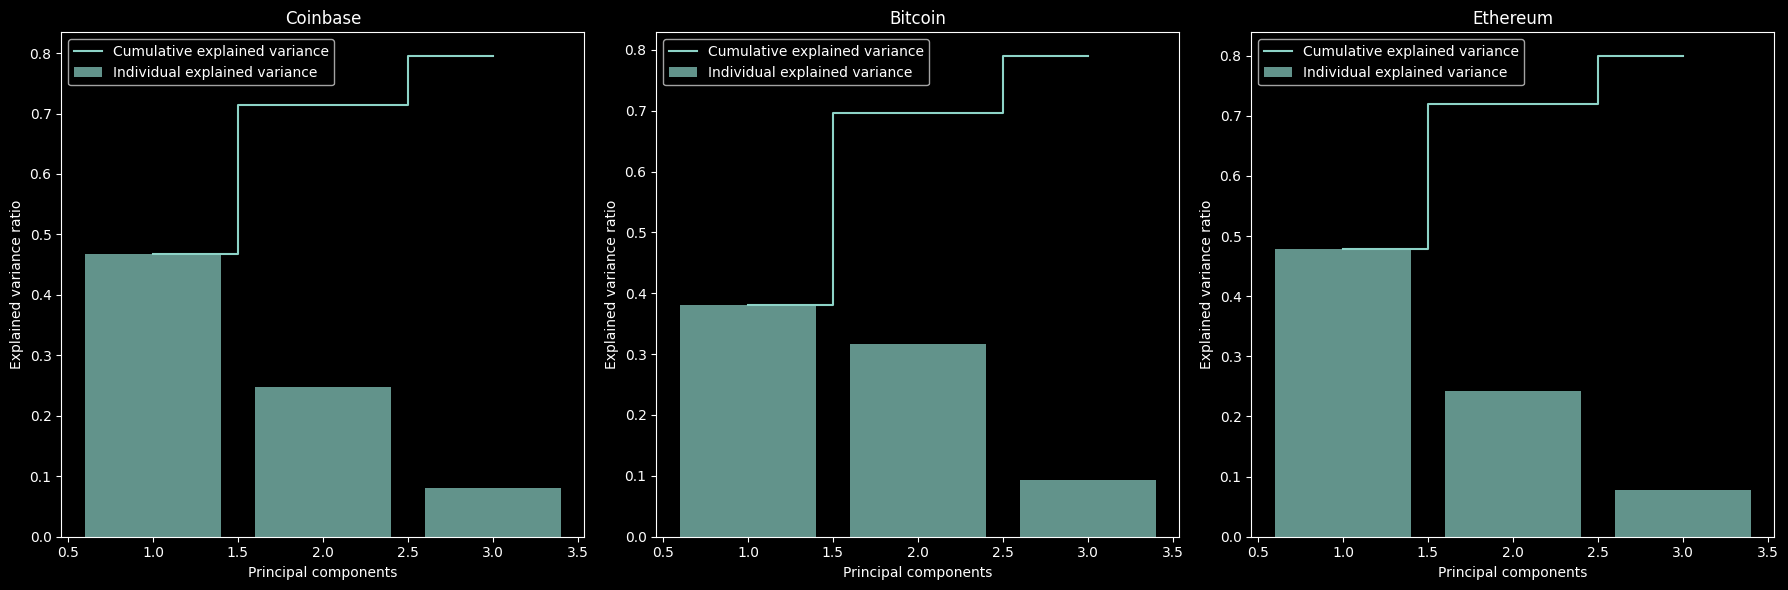

In [173]:
# Plotting the explained variance in three separate graphs
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Coinbase
axes[0].bar(
    range(1, len(coinbase_exp_var) + 1),
    coinbase_exp_var,
    alpha=0.7,
    align="center",
    label="Individual explained variance",
)
axes[0].step(
    range(1, len(coinbase_cum_exp_var) + 1),
    coinbase_cum_exp_var,
    where="mid",
    label="Cumulative explained variance",
)
axes[0].set_ylabel("Explained variance ratio")
axes[0].set_xlabel("Principal components")
axes[0].legend(loc="best")
axes[0].set_title("Coinbase")

# Bitcoin
axes[1].bar(
    range(1, len(bitcoin_exp_var) + 1),
    bitcoin_exp_var,
    alpha=0.7,
    align="center",
    label="Individual explained variance",
)
axes[1].step(
    range(1, len(bitcoin_cum_exp_var) + 1),
    bitcoin_cum_exp_var,
    where="mid",
    label="Cumulative explained variance",
)
axes[1].set_ylabel("Explained variance ratio")
axes[1].set_xlabel("Principal components")
axes[1].legend(loc="best")
axes[1].set_title("Bitcoin")

# Ethereum
axes[2].bar(
    range(1, len(ethereum_exp_var) + 1),
    ethereum_exp_var,
    alpha=0.7,
    align="center",
    label="Individual explained variance",
)
axes[2].step(
    range(1, len(ethereum_cum_exp_var) + 1),
    ethereum_cum_exp_var,
    where="mid",
    label="Cumulative explained variance",
)
axes[2].set_ylabel("Explained variance ratio")
axes[2].set_xlabel("Principal components")
axes[2].legend(loc="best")
axes[2].set_title("Ethereum")

plt.tight_layout()
plt.show()

### Interpret the results from the loadings and scores

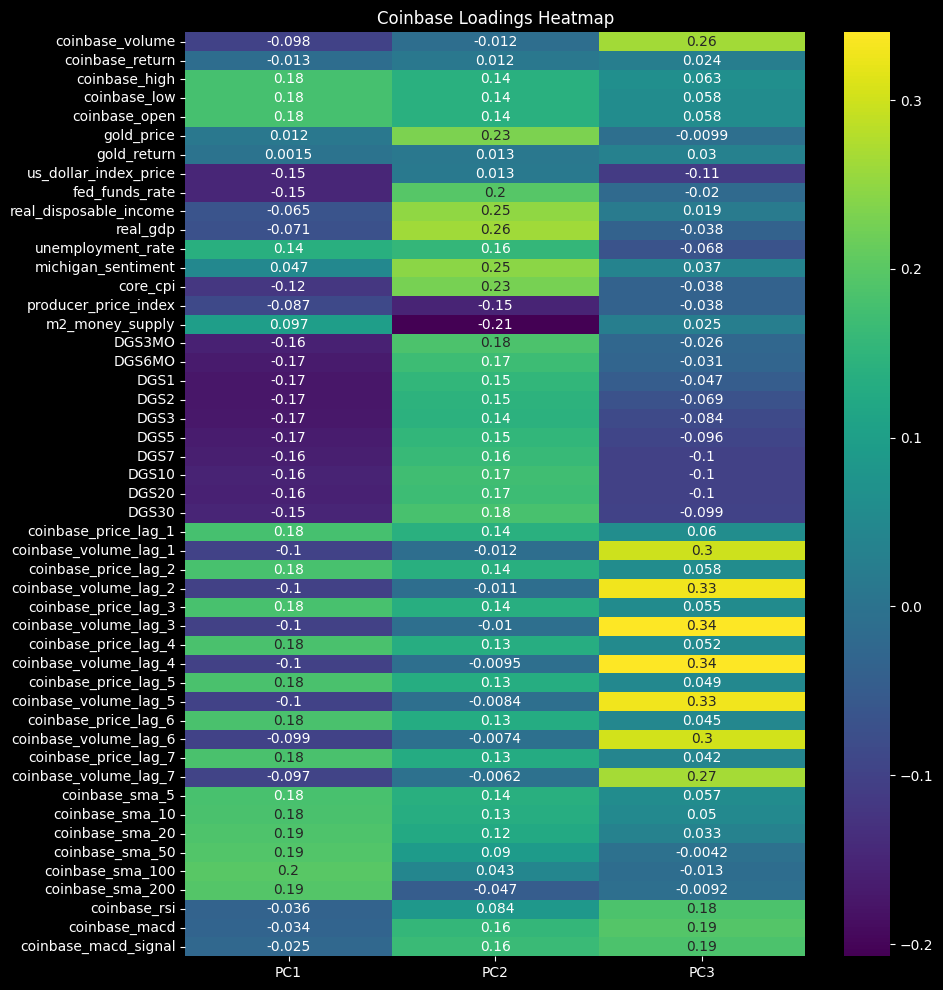

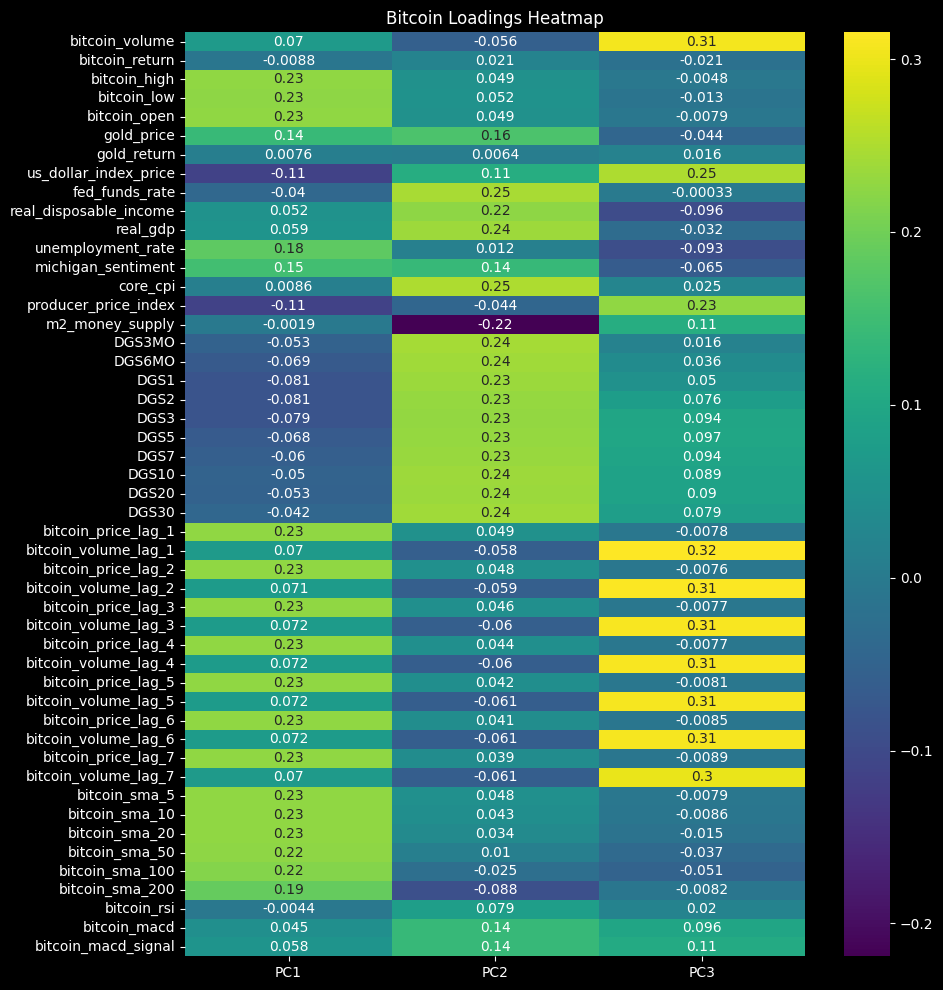

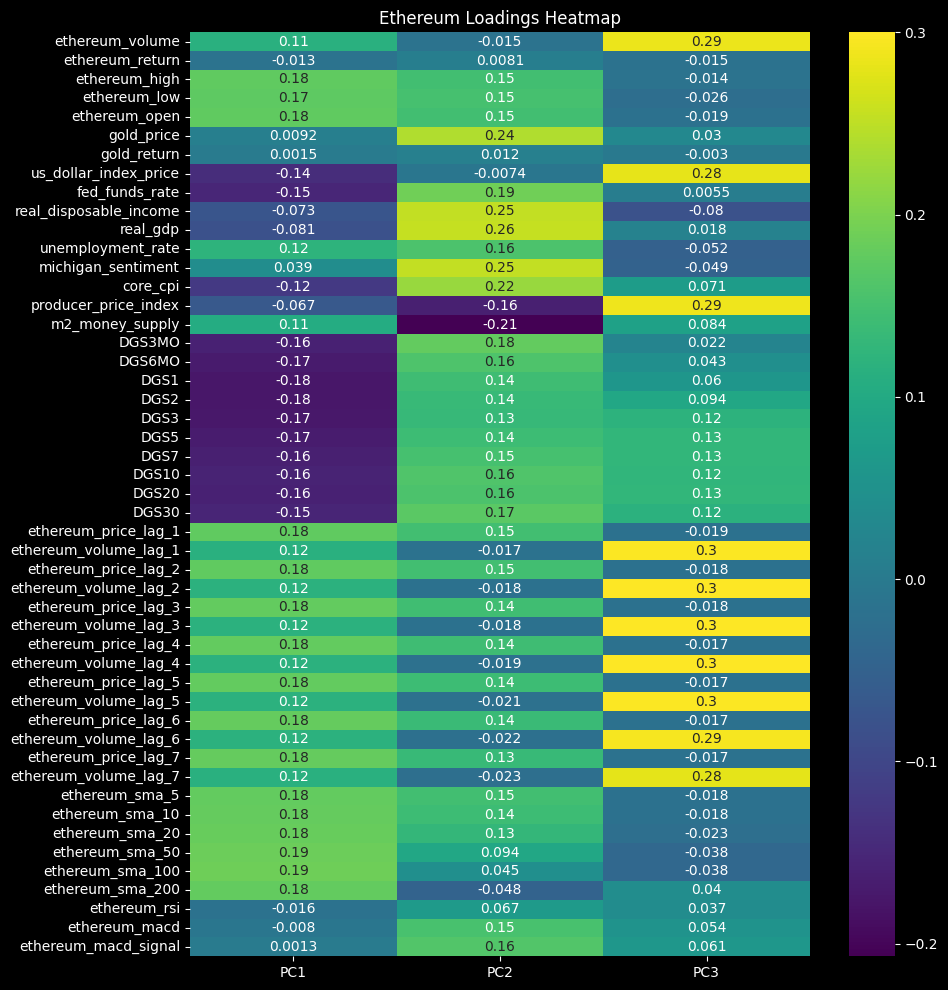

In [174]:
# Generate interaction terms for the feature names as well
def get_feature_names_with_interactions(X):
    """Generate feature names including interaction terms."""
    poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
    poly.fit(X)  # Fit to get feature names
    return poly.get_feature_names_out(X.columns)

# Get feature names for the original and interaction terms
coinbase_feature_names = get_feature_names_with_interactions(X_coinbase)
bitcoin_feature_names = get_feature_names_with_interactions(X_bitcoin)
ethereum_feature_names = get_feature_names_with_interactions(X_ethereum)

# Get the loadings (components) for each asset
coinbase_loadings = coinbase_pca.components_
bitcoin_loadings = bitcoin_pca.components_
ethereum_loadings = ethereum_pca.components_

# Create DataFrames for the loadings
coinbase_loadings_df = pd.DataFrame(
    coinbase_loadings.T,
    columns=[f"PC{i+1}" for i in range(coinbase_loadings.shape[0])],
    index=X_coinbase.columns,
)

bitcoin_loadings_df = pd.DataFrame(
    bitcoin_loadings.T,
    columns=[f"PC{i+1}" for i in range(bitcoin_loadings.shape[0])],
    index=X_bitcoin.columns,
)

ethereum_loadings_df = pd.DataFrame(
    ethereum_loadings.T,
    columns=[f"PC{i+1}" for i in range(ethereum_loadings.shape[0])],
    index=X_ethereum.columns,
)

# Plot heatmap for Coinbase loadings
plt.figure(figsize=(10, 12))
sns.heatmap(coinbase_loadings_df, annot=True, cmap="viridis")
plt.title("Coinbase Loadings Heatmap")
plt.show()

# Plot heatmap for Bitcoin loadings
plt.figure(figsize=(10, 12))
sns.heatmap(bitcoin_loadings_df, annot=True, cmap="viridis")
plt.title("Bitcoin Loadings Heatmap")
plt.show()

# Plot heatmap for Ethereum loadings
plt.figure(figsize=(10, 12))
sns.heatmap(ethereum_loadings_df, annot=True, cmap="viridis")
plt.title("Ethereum Loadings Heatmap")
plt.show()

## PCA Loadings

In [175]:
# Function to get the top features for each principal component
def get_top_features(loadings_df, component, top_n=10):
    loadings_df[f"{component}_abs"] = np.abs(loadings_df[component])
    sorted_loadings_df = loadings_df.sort_values(f"{component}_abs", ascending=False)
    return sorted_loadings_df[[component, f"{component}_abs"]].head(top_n)

# Coinbase
coinbase_loadings_df["PC1_abs"] = np.abs(coinbase_loadings_df["PC1"])
coinbase_loadings_df["PC2_abs"] = np.abs(coinbase_loadings_df["PC2"])
coinbase_loadings_df["PC3_abs"] = np.abs(coinbase_loadings_df["PC3"])

# Display the top 10 features with the highest absolute value of PC1 for Coinbase
print("Coinbase - Top 10 Features with the Highest Absolute Value of PC1:")
print(get_top_features(coinbase_loadings_df, "PC1"))

print("\nCoinbase - Top 10 Features with the Highest Absolute Value of PC2:")
print(get_top_features(coinbase_loadings_df, "PC2"))

print("\nCoinbase - Top 10 Features with the Highest Absolute Value of PC3:")
print(get_top_features(coinbase_loadings_df, "PC3"))

# Bitcoin
bitcoin_loadings_df["PC1_abs"] = np.abs(bitcoin_loadings_df["PC1"])
bitcoin_loadings_df["PC2_abs"] = np.abs(bitcoin_loadings_df["PC2"])
bitcoin_loadings_df["PC3_abs"] = np.abs(bitcoin_loadings_df["PC3"])

# Display the top 10 features with the highest absolute value of PC1 for Bitcoin
print("\nBitcoin - Top 10 Features with the Highest Absolute Value of PC1:")
print(get_top_features(bitcoin_loadings_df, "PC1"))

print("\nBitcoin - Top 10 Features with the Highest Absolute Value of PC2:")
print(get_top_features(bitcoin_loadings_df, "PC2"))

print("\nBitcoin - Top 10 Features with the Highest Absolute Value of PC3:")
print(get_top_features(bitcoin_loadings_df, "PC3"))

# Ethereum
ethereum_loadings_df["PC1_abs"] = np.abs(ethereum_loadings_df["PC1"])
ethereum_loadings_df["PC2_abs"] = np.abs(ethereum_loadings_df["PC2"])
ethereum_loadings_df["PC3_abs"] = np.abs(ethereum_loadings_df["PC3"])

# Display the top 10 features with the highest absolute value of PC1 for Ethereum
print("\nEthereum - Top 10 Features with the Highest Absolute Value of PC1:")
print(get_top_features(ethereum_loadings_df, "PC1"))

print("\nEthereum - Top 10 Features with the Highest Absolute Value of PC2:")
print(get_top_features(ethereum_loadings_df, "PC2"))

print("\nEthereum - Top 10 Features with the Highest Absolute Value of PC3:")
print(get_top_features(ethereum_loadings_df, "PC3"))

Coinbase - Top 10 Features with the Highest Absolute Value of PC1:
                           PC1   PC1_abs
coinbase_sma_100      0.197894  0.197894
coinbase_sma_200      0.194333  0.194333
coinbase_sma_50       0.192284  0.192284
coinbase_sma_20       0.186345  0.186345
coinbase_price_lag_7  0.183838  0.183838
coinbase_price_lag_6  0.183279  0.183279
coinbase_sma_10       0.182875  0.182875
coinbase_price_lag_5  0.182648  0.182648
coinbase_price_lag_4  0.181914  0.181914
coinbase_price_lag_3  0.181157  0.181157

Coinbase - Top 10 Features with the Highest Absolute Value of PC2:
                             PC2   PC2_abs
real_gdp                0.261144  0.261144
real_disposable_income  0.250082  0.250082
michigan_sentiment      0.245589  0.245589
gold_price              0.233017  0.233017
core_cpi                0.226991  0.226991
m2_money_supply        -0.207280  0.207280
fed_funds_rate          0.195854  0.195854
DGS3MO                  0.184160  0.184160
DGS30                   0.1

In [176]:
import altair as alt

# Create a DataFrame for the Coinbase principal components
coinbase_pca_df = pd.DataFrame(
    data=coinbase_principal_components,
    columns=[f"PC{i+1}" for i in range(3)]
)

# Add the target variable to the DataFrame
coinbase_pca_df["coinbase_price"] = y_coinbase.values

# Create a scatter plot of PC1 and PC2 colored by the target variable
coin1 = alt.Chart(coinbase_pca_df).mark_circle(size=60).encode(
    x="PC1",
    y="PC2",
    color=alt.Color("coinbase_price", title="Coinbase Price"),
    tooltip=["coinbase_price"]
)

# Create a scatter plot of PC1 and PC3 colored by the target variable
coin2 = alt.Chart(coinbase_pca_df).mark_circle(size=60).encode(
    x="PC1",
    y="PC3",
    color="coinbase_price",
    tooltip=["coinbase_price"]
)

# Create a scatter plot of PC2 and PC3 colored by the target variable
coin3 = alt.Chart(coinbase_pca_df).mark_circle(size=60).encode(
    x="PC2",
    y="PC3",
    color="coinbase_price",
    tooltip=["coinbase_price"]
)

# Display the scatter plots
coinbase_pca_chart = coin1 | coin2 | coin3

coinbase_pca_chart

alt.HConcatChart(...)

In [177]:
# Create a DataFrame for the Bitcoin principal components
bitcoin_pca_df = pd.DataFrame(
    data=bitcoin_principal_components,
    columns=[f"PC{i+1}" for i in range(3)]
)

# Add the target variable to the DataFrame
bitcoin_pca_df["bitcoin_price"] = y_bitcoin.values

# Create a scatter plot of PC1 and PC2 colored by the target variable
bitcoin1 = alt.Chart(bitcoin_pca_df).mark_circle(size=60).encode(
    x="PC1",
    y="PC2",
    color=alt.Color("bitcoin_price", title="Bitcoin Price"),
    tooltip=["bitcoin_price"]
)

# Create a scatter plot of PC1 and PC3 colored by the target variable
bitcoin2 = alt.Chart(bitcoin_pca_df).mark_circle(size=60).encode(
    x="PC1",
    y="PC3",
    color="bitcoin_price",
    tooltip=["bitcoin_price"]
)

# Create a scatter plot of PC2 and PC3 colored by the target variable
bitcoin3 = alt.Chart(bitcoin_pca_df).mark_circle(size=60).encode(
    x="PC2",
    y="PC3",
    color="bitcoin_price",
    tooltip=["bitcoin_price"]
)

# Display the scatter plots
bitcoin_pca_chart = bitcoin1 | bitcoin2 | bitcoin3

bitcoin_pca_chart

alt.HConcatChart(...)

In [178]:
# Create a DataFrame for the Bitcoin principal components
ethereum_pca_df = pd.DataFrame(
    data=ethereum_principal_components,
    columns=[f"PC{i+1}" for i in range(3)]
)

# Add the target variable to the DataFrame
ethereum_pca_df["ethereum_price"] = y_ethereum.values

# Create a scatter plot of PC1 and PC2 colored by the target variable
ethereum1 = alt.Chart(ethereum_pca_df).mark_circle(size=60).encode(
    x="PC1",
    y="PC2",
    color=alt.Color("ethereum_price", title="Ethereum Price"),
    tooltip=["ethereum_price"]
)

# Create a scatter plot of PC1 and PC3 colored by the target variable
ethereum2 = alt.Chart(ethereum_pca_df).mark_circle(size=60).encode(
    x="PC1",
    y="PC3",
    color="ethereum_price",
    tooltip=["ethereum_price"]
)

# Create a scatter plot of PC2 and PC3 colored by the target variable
ethereum3 = alt.Chart(ethereum_pca_df).mark_circle(size=60).encode(
    x="PC2",
    y="PC3",
    color="ethereum_price",
    tooltip=["ethereum_price"]
)

# Display the scatter plots
ethereum_pca_chart = ethereum1 | ethereum2 | ethereum3

ethereum_pca_chart

alt.HConcatChart(...)

In [179]:
# Concat vertically with separate color scales
alt.vconcat(coinbase_pca_chart, bitcoin_pca_chart, ethereum_pca_chart).resolve_scale(color="independent")

alt.VConcatChart(...)

## Linear Regression on the PCA Components

In [180]:
# Perform a linear regression on the PCA components using returns as the target variable
from sklearn.linear_model import LinearRegression

# Define the target variable
y_coinbase_ret = coinbase_data["coinbase_return"]
y_bitcoin_ret = bitcoin_data["bitcoin_return"]
y_ethereum_ret = ethereum_data["ethereum_return"]

# Define the features
X_coinbase_pca = coinbase_principal_components
X_bitcoin_pca = bitcoin_principal_components
X_ethereum_pca = ethereum_principal_components

# Initialize and fit the linear regression model for Coinbase
linreg_coinbase = LinearRegression()
linreg_coinbase.fit(X_coinbase_pca, y_coinbase_ret)

# Initialize and fit the linear regression model for Bitcoin
linreg_bitcoin = LinearRegression()
linreg_bitcoin.fit(X_bitcoin_pca, y_bitcoin_ret)

# Initialize and fit the linear regression model for Ethereum
linreg_ethereum = LinearRegression()
linreg_ethereum.fit(X_ethereum_pca, y_ethereum_ret)

# Get the R-squared values
r2_coinbase = linreg_coinbase.score(X_coinbase_pca, y_coinbase_ret)
r2_bitcoin = linreg_bitcoin.score(X_bitcoin_pca, y_bitcoin_ret)
r2_ethereum = linreg_ethereum.score(X_ethereum_pca, y_ethereum_ret)

# Display the R-squared values
r2_coinbase, r2_bitcoin, r2_ethereum

(0.008177455795188582, 0.010096173689869037, 0.005631285390060303)

In [181]:
# Define the target variable
y_coinbase_ret = coinbase_data["coinbase_return"]

# Define the features
X_coinbase_pc1 = coinbase_principal_components[:, 0].reshape(-1, 1)

# Initialize and fit the linear regression model
linreg_coinbase = LinearRegression()
linreg_coinbase.fit(X_coinbase_pc1, y_coinbase_ret)

# Get the R-squared value
r2_coinbase_pc1 = linreg_coinbase.score(X_coinbase_pc1, y_coinbase_ret)

# Display the R-squared value
r2_coinbase_pc1

0.0041296429211076235

In [182]:
# Define the target variable
y_coinbase_ret = coinbase_data["coinbase_return"]

# Define the features
X_coinbase_pc2 = coinbase_principal_components[:, 1].reshape(-1, 1)

# Initialize and fit the linear regression model
linreg_coinbase = LinearRegression()
linreg_coinbase.fit(X_coinbase_pc2, y_coinbase_ret)

# Get the R-squared value
r2_coinbase_pc2 = linreg_coinbase.score(X_coinbase_pc2, y_coinbase_ret)

# Display the R-squared value
r2_coinbase_pc2

0.0017364032583202516

In [183]:
# Define the target variable
y_coinbase_ret = coinbase_data["coinbase_return"].reset_index(drop=True)

# Define the features (using the first few principal components)
X_coinbase_pca = coinbase_principal_components[:, :3]  # Example with the first 3 principal components

# Initialize and fit the linear regression model
linreg_coinbase = LinearRegression()
linreg_coinbase.fit(X_coinbase_pca, y_coinbase_ret)

# Get the R-squared value
r2_coinbase_pca = linreg_coinbase.score(X_coinbase_pca, y_coinbase_ret)

# Display the R-squared value
r2_coinbase_pca

0.008177455795188582

In [184]:
from sklearn.preprocessing import PolynomialFeatures

# Define the features (using the first three principal components)
X_coinbase_pca_3 = coinbase_principal_components[:, :3]

# Create polynomial features
poly = PolynomialFeatures(degree=2)
X_coinbase_poly = poly.fit_transform(X_coinbase_pca_3)

# Initialize and fit the polynomial regression model
polyreg_coinbase = LinearRegression()
polyreg_coinbase.fit(X_coinbase_poly, y_coinbase_ret)

# Get the R-squared value
r2_coinbase_poly = polyreg_coinbase.score(X_coinbase_poly, y_coinbase_ret)

# Display the R-squared value
r2_coinbase_poly

0.016940448161329003

In [185]:
from sklearn.ensemble import RandomForestRegressor

# Define the features (using the first three principal components)
X_coinbase_pca_3 = coinbase_principal_components[:, :3]
#X_coinbase_pc1 = coinbase_principal_components[:, 0].reshape(-1, 1)

# Initialize and fit the Random Forest model
rf_coinbase = RandomForestRegressor(n_estimators=100, random_state=42)
rf_coinbase.fit(X_coinbase_pca_3, y_coinbase_ret)

# Get the R-squared value
r2_rf_coinbase = rf_coinbase.score(X_coinbase_pca_3, y_coinbase_ret)

# Display the R-squared value
r2_rf_coinbase

0.8337772135337784